This notebook is part of the $\omega radlib$ documentation: https://docs.wradlib.org.

Copyright (c) $\omega radlib$ developers.
Distributed under the MIT License. See LICENSE.txt for more info.

# xarray IRIS backend

In this example, we read IRIS (sigmet) data files using the xradar `iris` xarray backend.

In [1]:
import glob
import gzip
import io
import wradlib as wrl
import warnings

warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import numpy as np
import xradar as xd
import datatree as xt
import xarray as xr

try:
    get_ipython().run_line_magic("matplotlib inline")
except:
    plt.ion()

## Load IRIS Volume Data

In [2]:
fpath = "sigmet/SUR210819000227.RAWKPJV"
f = wrl.util.get_wradlib_data_file(fpath)
vol = xd.io.open_iris_datatree(f, reindex_angle=False)

## Inspect RadarVolume

In [3]:
display(vol)

DataTree('root', parent=None)
│   Dimensions:              ()
│   Data variables:
│       volume_number        int64 0
│       platform_type        <U5 'fixed'
│       instrument_type      <U5 'radar'
│       time_coverage_start  <U20 '2021-08-19T00:02:28Z'
│       time_coverage_end    <U20 '2021-08-19T00:02:49Z'
│       longitude            float64 25.52
│       altitude             float64 157.0
│       latitude             float64 58.48
│   Attributes:
│       Conventions:      None
│       version:          None
│       title:            None
│       institution:      None
│       references:       None
│       source:           None
│       history:          None
│       comment:          im/exported using xradar
│       instrument_name:  None
└── DataTree('sweep_0')
        Dimensions:            (azimuth: 359, range: 833)
        Coordinates:
            elevation          (azimuth) float32 ...
            time               (azimuth) datetime64[ns] 2021-08-19T00:02:31.104000 .....
          * range              (range) float32 150.0 450.0 750.0 ... 2.494e+05 2.498e+05
            longitude          float64 ...
            latitude           float64 ...
            altitude           float64 ...
          * azimuth            (azimuth) float32 0.03021 1.035 2.054 ... 358.0 359.0
        Data variables: (12/16)
            DBTH               (azimuth, range) float32 ...
            DBZH               (azimuth, range) float32 ...
            VRADH              (azimuth, range) float32 ...
            WRADH              (azimuth, range) float32 ...
            ZDR                (azimuth, range) float32 ...
            KDP                (azimuth, range) float32 ...
            ...                 ...
            SNRH               (azimuth, range) float32 ...
            sweep_mode         <U20 ...
            sweep_number       int64 ...
            prt_mode           <U7 ...
            follow_mode        <U7 ...
            sweep_fixed_angle  float64 ...

## Inspect root group

The `sweep` dimension contains the number of scans in this radar volume. Further the dataset consists of variables (location coordinates, time_coverage) and attributes (Conventions, metadata).

In [4]:
vol.root

DataTree('root', parent=None)
│   Dimensions:              ()
│   Data variables:
│       volume_number        int64 0
│       platform_type        <U5 'fixed'
│       instrument_type      <U5 'radar'
│       time_coverage_start  <U20 '2021-08-19T00:02:28Z'
│       time_coverage_end    <U20 '2021-08-19T00:02:49Z'
│       longitude            float64 25.52
│       altitude             float64 157.0
│       latitude             float64 58.48
│   Attributes:
│       Conventions:      None
│       version:          None
│       title:            None
│       institution:      None
│       references:       None
│       source:           None
│       history:          None
│       comment:          im/exported using xradar
│       instrument_name:  None
└── DataTree('sweep_0')
        Dimensions:            (azimuth: 359, range: 833)
        Coordinates:
            elevation          (azimuth) float32 ...
            time               (azimuth) datetime64[ns] 2021-08-19T00:02:31.104000 .....
          * range              (range) float32 150.0 450.0 750.0 ... 2.494e+05 2.498e+05
            longitude          float64 ...
            latitude           float64 ...
            altitude           float64 ...
          * azimuth            (azimuth) float32 0.03021 1.035 2.054 ... 358.0 359.0
        Data variables: (12/16)
            DBTH               (azimuth, range) float32 ...
            DBZH               (azimuth, range) float32 ...
            VRADH              (azimuth, range) float32 ...
            WRADH              (azimuth, range) float32 ...
            ZDR                (azimuth, range) float32 ...
            KDP                (azimuth, range) float32 ...
            ...                 ...
            SNRH               (azimuth, range) float32 ...
            sweep_mode         <U20 ...
            sweep_number       int64 ...
            prt_mode           <U7 ...
            follow_mode        <U7 ...
            sweep_fixed_angle  float64 ...

## Inspect sweep group(s)

The sweep-groups can be accessed via their respective keys. The dimensions consist of `range` and `time` with added coordinates `azimuth`, `elevation`, `range` and `time`. There will be variables like radar moments (DBZH etc.) and sweep-dependend metadata (like `fixed_angle`, `sweep_mode` etc.).

In [5]:
display(vol["sweep_0"])

DataTree('sweep_0', parent="root")
    Dimensions:            (azimuth: 359, range: 833)
    Coordinates:
        elevation          (azimuth) float32 ...
        time               (azimuth) datetime64[ns] 2021-08-19T00:02:31.104000 .....
      * range              (range) float32 150.0 450.0 750.0 ... 2.494e+05 2.498e+05
        longitude          float64 ...
        latitude           float64 ...
        altitude           float64 ...
      * azimuth            (azimuth) float32 0.03021 1.035 2.054 ... 358.0 359.0
    Data variables: (12/16)
        DBTH               (azimuth, range) float32 ...
        DBZH               (azimuth, range) float32 ...
        VRADH              (azimuth, range) float32 ...
        WRADH              (azimuth, range) float32 ...
        ZDR                (azimuth, range) float32 ...
        KDP                (azimuth, range) float32 ...
        ...                 ...
        SNRH               (azimuth, range) float32 ...
        sweep_mode         <U20 ...
        sweep_number       int64 ...
        prt_mode           <U7 ...
        follow_mode        <U7 ...
        sweep_fixed_angle  float64 ...

## Georeferencing

In [6]:
swp = vol["sweep_0"].ds.copy()
swp = swp.assign_coords(sweep_mode=swp.sweep_mode)
swp = swp.wrl.georef.georeference()

## Inspect radar moments

The DataArrays can be accessed by key or by attribute. Each DataArray has dimensions and coordinates of it's parent dataset.

In [7]:
display(swp.DBZH)

<xarray.DataArray 'DBZH' (azimuth: 359, range: 833)>
[299047 values with dtype=float32]
Coordinates: (12/15)
    elevation   (azimuth) float64 0.5054 0.5054 0.5054 ... 0.5054 0.5054 0.5054
    time        (azimuth) datetime64[ns] 2021-08-19T00:02:31.104000 ... 2021-...
  * range       (range) float32 150.0 450.0 750.0 ... 2.494e+05 2.498e+05
    longitude   float64 25.52
    latitude    float64 58.48
    altitude    float64 157.0
    ...          ...
    y           (azimuth, range) float64 150.0 450.0 ... 2.493e+05 2.496e+05
    z           (azimuth, range) float64 158.3 161.0 ... 6.023e+03 6.034e+03
    gr          (azimuth, range) float64 150.0 450.0 ... 2.493e+05 2.496e+05
    rays        (azimuth, range) float32 0.03021 0.03021 0.03021 ... 359.0 359.0
    bins        (azimuth, range) float32 150.0 450.0 ... 2.494e+05 2.498e+05
    crs_wkt     int64 0
Attributes:
    standard_name:  radar_equivalent_reflectivity_factor_h
    units:          dBZ
    long_name:      Equivalent reflectivity factor H

## Create simple plot

Using xarray features a simple plot can be created like this. Note the `sortby('time')` method, which sorts the radials by time.

For more details on plotting radar data see under [Visualization](../../plotting.ipynb).

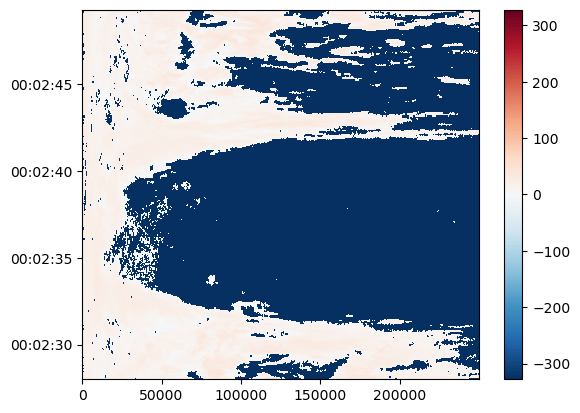

In [8]:
swp.DBZH.sortby("time").plot(x="range", y="time", add_labels=False)

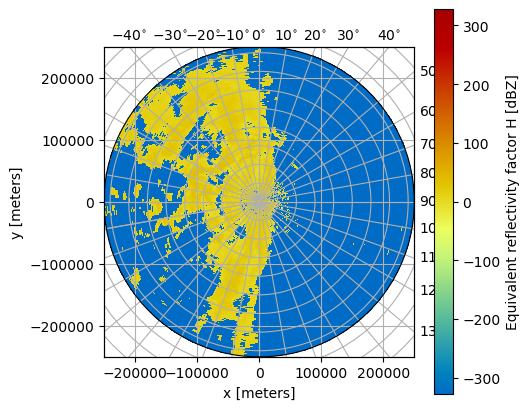

In [9]:
fig = plt.figure(figsize=(5, 5))
pm = swp.DBZH.wrl.vis.plot(crs={"latmin": 3e3}, fig=fig)

## Retrieve explicit group

In [10]:
swp_b = xr.open_dataset(
    f, engine="iris", group="sweep_0", backend_kwargs=dict(reindex_angle=False)
)
display(swp_b)

<xarray.Dataset>
Dimensions:            (azimuth: 359, range: 833)
Coordinates:
    elevation          (azimuth) float32 ...
    time               (azimuth) datetime64[ns] ...
  * range              (range) float32 150.0 450.0 750.0 ... 2.494e+05 2.498e+05
    longitude          float64 ...
    latitude           float64 ...
    altitude           float64 ...
  * azimuth            (azimuth) float32 0.03021 1.035 2.054 ... 358.0 359.0
Data variables: (12/16)
    DBTH               (azimuth, range) float32 ...
    DBZH               (azimuth, range) float32 ...
    VRADH              (azimuth, range) float32 ...
    WRADH              (azimuth, range) float32 ...
    ZDR                (azimuth, range) float32 ...
    KDP                (azimuth, range) float32 ...
    ...                 ...
    SNRH               (azimuth, range) float32 ...
    sweep_mode         <U20 ...
    sweep_number       int64 ...
    prt_mode           <U7 ...
    follow_mode        <U7 ...
    sweep_fixed_angle  float64 ...